# LATENT DIRICHLET ALLOCATION (LDA) TOPIC MODELING

In this notebook, we will see **how to run the LDA version of topic modeling** and **how to use the outputs** generated by the algorithm.  

In more details, this code will help you  performing the following **steps** :
*   Run a topic model on a large corpus of text
*   Understand the structure of the outputs generated by LDA
*   Interpret the topics generated by the algorithm

We will perform the steps above on a corpus of text that comprises all the reviews that **Chimera** employees post about their company on the website **Glassdoor.com**. The employee reviews are structured in a way that allows users to separate the "pros" and "cons" of their organization when posting the content on Glassdoor. The analysis can be repeated for the "pros" and "cons" separately.

Notice: the code is set up to run on the "pros" section of the Glassdoor reviews only. To perform the analysis on the "cons", you only need to adjust which of the Excel sheets gets loaded.

## Step 0: Set up

**Modules import**

Let's start by importing the modules needed to run the algorithm. Two libraries you probably haven't installed yet are `openpyxl` and `spacy`, so let's take care of that (note, `openpyxl` is not loaded here separately, but is used by pandas to open xlsx files). Within `spacy`, we will also use the `en_core_web_sm` library, which we need to download directly from Github.

In [10]:
# conda install openpyxl

In [11]:
# pip install spacy

In [12]:
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [13]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('wordnet')
import matplotlib.pyplot as plt
import spacy
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mattheus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 1: Upload the corpus of text to analyse with topic modeling

**Import Glassdoor review data**

Load Excel spreasheet storing the Chimera review data available on Glassdoor and inspect it:

In [14]:
# isolate "pros" section of reviews
chimera_df = pd.read_excel("ReviewData.xlsx", sheet_name = 'Pros')
chimera_df.head()

,Review text-pros
0,You will be working with the most talented ppl...
1,Freedom and responsibility. You're treated lik...
2,Great colleagues -- incredible really
3,The upper management of Chimera really does se...
4,"The people there are fantastic, the service is..."


**Extract review text to analyse**

From `chimera_df`, isolate the reviews text to analyse with topic modeling and do some pre-cleaning on the strings of text.

In [15]:
chimera_df = chimera_df.fillna('')
data_pros = chimera_df['Review text-pros'].tolist()
data_pros_cleaned = []
for item in data_pros:
    if item != "":
        item_modified = item.lower().replace("chimera", " ") # the company name will not be meaningful to interpretation
        item_modified = item_modified.replace("show less", "") # Show less and show more buttons are left-over from the data entry froms
        item_modified = item_modified.replace("show more", "")
        item_modified = item_modified.replace("\n", " ") # \n indicate line-breaks that we do not care about
        item_modified = item_modified.replace("_x000d_", "") # when reading data from .xlsx files, this will appear around line breaks
        item_modified = item_modified.replace(".", "") # Remove periods
        item_modified = item_modified.replace(",", "") # Remove commata
        item_modified = item_modified.replace("-", " ") # Remove dashes
        item_modified = re.sub(r"\s+", " ", item_modified) # Remove extra whitespace
        item_modified =  ''.join([i for i in item_modified if not i.isdigit()]) # taking out numbers
        data_pros_cleaned.append(item_modified)

data_pros_cleaned[0:5]

['you will be working with the most talented ppl around',
 "freedom and responsibility you're treated like an adult you're part of a pro team that is highly functioning the company is well respected and has a super positive brand awareness i'm never able to go anywhere without getting peppered with raves and happy customer comments and i love wearing company logo gear when i'm out for this reason you matter at there is no dead wood everyone is doing something very important to the company or they wouldn't be there what you are doing matters and makes a difference and that feels good you can really make a difference no matter what your role the company often repeats that as an employee you're not on an olympic team meaning you don't do this / with no life with all focus on the gold we're more of a varsity team playing to win very good but still have to balance with classes and learning we need to have a good work/life balance and its very important to the company that we do i think the 



---



### Step 1.1: More on data cleaning

The next few steps will provide you an example of lemmatization (similar to stemming) and removal of stop words, both necessary cleaning steps to perform prior to running the topic model. 

As an example, we will use the spacy library English language model. 

In [16]:
nlp = spacy.load('en_core_web_sm') # we first load the English language model

Let's use one review from the corpus as an example:

In [17]:
example_review = data_pros_cleaned[5]
parsed_review = nlp(example_review)
print (parsed_review)

benefits are terrific and i have my perfect shift free movies are always wonderful this is the perfect job for me because it really is low stress and it is a perfect avenue for my love of film film history and general film knowledge


We will next inspect each "token" in our sample review parsed_review, understand what lemmatizing means, and figure out whether each word should be kept in the review for the final analysis or not. 

In [18]:
# take out individual tokens from parsed review
token_text = [token.text for token in parsed_review]
print(token_text)

['benefits', 'are', 'terrific', 'and', 'i', 'have', 'my', 'perfect', 'shift', 'free', 'movies', 'are', 'always', 'wonderful', 'this', 'is', 'the', 'perfect', 'job', 'for', 'me', 'because', 'it', 'really', 'is', 'low', 'stress', 'and', 'it', 'is', 'a', 'perfect', 'avenue', 'for', 'my', 'love', 'of', 'film', 'film', 'history', 'and', 'general', 'film', 'knowledge']


In [19]:
# lemmatize words
token_lemmas = [token.lemma_ for token in parsed_review]
print(token_lemmas)

['benefit', 'be', 'terrific', 'and', 'I', 'have', 'my', 'perfect', 'shift', 'free', 'movie', 'be', 'always', 'wonderful', 'this', 'be', 'the', 'perfect', 'job', 'for', 'I', 'because', 'it', 'really', 'be', 'low', 'stress', 'and', 'it', 'be', 'a', 'perfect', 'avenue', 'for', 'my', 'love', 'of', 'film', 'film', 'history', 'and', 'general', 'film', 'knowledge']


In [20]:
# check if token is a stop word
token_stop = [token.is_stop for token in parsed_review]
for t in range(len(token_lemmas)):
    if token_stop[t]:
        print("Token '" + token_lemmas[t] + "' is a stopword")
    else:
        print("Token '" + token_lemmas[t] + "' is not a stopword")

Token 'benefit' is not a stopword
Token 'be' is a stopword
Token 'terrific' is not a stopword
Token 'and' is a stopword
Token 'I' is a stopword
Token 'have' is a stopword
Token 'my' is a stopword
Token 'perfect' is not a stopword
Token 'shift' is not a stopword
Token 'free' is not a stopword
Token 'movie' is not a stopword
Token 'be' is a stopword
Token 'always' is a stopword
Token 'wonderful' is not a stopword
Token 'this' is a stopword
Token 'be' is a stopword
Token 'the' is a stopword
Token 'perfect' is not a stopword
Token 'job' is not a stopword
Token 'for' is a stopword
Token 'I' is a stopword
Token 'because' is a stopword
Token 'it' is a stopword
Token 'really' is a stopword
Token 'be' is a stopword
Token 'low' is not a stopword
Token 'stress' is not a stopword
Token 'and' is a stopword
Token 'it' is a stopword
Token 'be' is a stopword
Token 'a' is a stopword
Token 'perfect' is not a stopword
Token 'avenue' is not a stopword
Token 'for' is a stopword
Token 'my' is a stopword
Tok

In [21]:
# assemble results for inspection
pd.DataFrame(zip(token_text, token_lemmas, token_stop), columns=['Original Text', 'Stemmed Text', 'stopwords']).head(20)

,Original Text,Stemmed Text,stopwords
0,benefits,benefit,False
1,are,be,True
2,terrific,terrific,False
3,and,and,True
4,i,I,True
5,have,have,True
6,my,my,True
7,perfect,perfect,False
8,shift,shift,False
9,free,free,False


### Step 1.2: The actual stemming process

We actually stem the text in the corpus using a `nltk` based class, but we won't see very much of the process. Don't worry about the details here!

In [22]:
snowball_stemmer = nltk.stem.SnowballStemmer('english')
class SBStemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(SBStemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([snowball_stemmer.stem(w) for w in analyzer(doc)])

In [23]:
tf_vectorizer = SBStemmedCountVectorizer(max_df = 0.9, min_df=0.01, analyzer="word", stop_words='english') #max min required occurrence of word, english stop words
tf = tf_vectorizer.fit_transform(data_pros_cleaned) # vectorize data (learn the vocabulary dictionary and return term-document matrix)
voc = tf_vectorizer.get_feature_names() # extract features

C:\Users\Mattheus\anaconda3\envs\smm750\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Step 2: Run LDA Topic Model

**Hyper-parameter tuning** is an essential step in using any ML algorithm and it is one of the main steps prior to actually run the LDA model. 

We will not discuss how parameters are tuned here, but you can see some details further below in the notebook.

**Select optimal topic number, K**

Based on the result of a computation-heavy step that has been already run in background (coherence maximization algorithm to tune number of topics K), we will select the optimal number of topics to fit the topic model on the Glassdoor reviews available for Chimera.

While we could be running the topic model with an arbitrary number of topics, tuning such a parameter is very important, as it (1) favours the accuracy of how data are represented as topics, and (2) increases the replicability of results.

In [24]:
optimal_topics_pros = 157  # For cons: 207

**Run LDA topic model on review text with optimal topic number**

We will fit the LDA topic model on the "pros" and "cons" sections of the Chimera text reviews, separately. 

LDA takes as an input a matrix of documents X words (terms), generated through the vectorization stage. 

You can find more details about how to run LDA using the sklearn library (e.g., about the meaning of the various parameters in the function, and how to best tune those) [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html):

In [25]:
lda = LatentDirichletAllocation(n_components=optimal_topics_pros, max_iter=200, learning_method='batch', learning_offset=10.,evaluate_every=2,random_state=1234)
lda_fit = lda.fit(tf)

### Step 2.1: LDA output - Topic-over-word matrix

We are finally able to generate one of the two main outputs of the topic model: a **matrix summarizing the distribution of the topics** estimated by LDA **over the words forming the corpus vocabulary** (i.e., all the unique words that appear in the documents).

Let's start by **visualizing the vocabulary**, how big it is, and the words it comprises: 

In [26]:
# print length of vocabulary list
len(voc)

340

In [27]:
# print words forming the vocabulary
voc

['abil',
 'abl',
 'account',
 'actual',
 'adult',
 'allow',
 'amaz',
 'appreci',
 'approv',
 'area',
 'ask',
 'atmospher',
 'autonomi',
 'avail',
 'averag',
 'awesom',
 'balanc',
 'base',
 'benefit',
 'best',
 'better',
 'big',
 'bonus',
 'brand',
 'break',
 'bright',
 'brilliant',
 'bring',
 'build',
 'busi',
 'cafeteria',
 'capabl',
 'care',
 'career',
 'cater',
 'center',
 'ceo',
 'challeng',
 'chang',
 'cheap',
 'clean',
 'clear',
 'code',
 'coffe',
 'collabor',
 'colleagu',
 'come',
 'communic',
 'compani',
 'compens',
 'compet',
 'competit',
 'complet',
 'consid',
 'consist',
 'constant',
 'continu',
 'cool',
 'corpor',
 'cowork',
 'creat',
 'creativ',
 'cultur',
 'custom',
 'cut',
 'data',
 'day',
 'decent',
 'decid',
 'decis',
 'deck',
 'deliv',
 'dental',
 'depart',
 'develop',
 'did',
 'differ',
 'direct',
 'do',
 'doe',
 'doesn',
 'don',
 'dress',
 'drink',
 'drive',
 'driven',
 'dvd',
 'dynam',
 'easi',
 'edg',
 'employ',
 'employe',
 'encourag',
 'engag',
 'engin',
 'enjoy

Let's now generate the **matrix summarizing the distributions of topics over words** and inspect it. 

As we will see below, this matrix can be used to interpret the meaning of the topics estimated by LDA. 

In [28]:
# distribution of topics over words in vocabulary
topics_words = lda_fit.components_ / lda_fit.components_.sum(axis=1)[:, np.newaxis]
topics_words_df = pd.DataFrame(topics_words)
topics_words_df.shape

(157, 340)

In [29]:
# inspect matrix
topics_words_df.head()

,0,1,2,3,4,5,6,7,8,9,...,330,331,332,333,334,335,336,337,338,339
0,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.041499,0.000263,0.000263,0.000263,...,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263,0.000263
1,0.000086,0.000086,0.000086,0.013569,0.000086,0.000086,0.000086,0.000086,0.000086,0.000086,...,0.013569,0.000086,0.000086,0.000086,0.000086,0.000086,0.080986,0.000086,0.000086,0.000086
2,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,...,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.156698,0.000045,0.000045,0.000045
3,0.021558,0.000136,0.000136,0.000136,0.021558,0.064401,0.000136,0.000136,0.000136,0.000136,...,0.000136,0.000136,0.021558,0.000136,0.000136,0.000136,0.058415,0.000136,0.000136,0.000136
4,0.000154,0.000154,0.000154,0.000154,0.024271,0.000154,0.000154,0.000154,0.000154,0.000154,...,0.000154,0.000154,0.000154,0.000154,0.024271,0.000154,0.000154,0.000154,0.024271,0.000154


### Step 2.2: LDA output - Document-over-topic matrix

The second output of interest, which we are going to generate and inspect below, is a **matrix summarizing the distribution of documents** (i.e., employee reviews, in our context) **over the topics** (i.e., lists of words that, statistically, co-occur across the reviews more likely than others) estimated by LDA. 

As we will see below, this matrix can be used to compute summary statistics and to interpret the topics. 

In [30]:
# distribution of documents over topics
docs_topics = lda.transform(tf)
docs_topics_df = pd.DataFrame(data = docs_topics, index=None, columns=None, dtype=None, copy=False)
docs_topics_df.shape

(692, 157)

In [31]:
# inspect matrix
docs_topics_df.head()

,0,1,2,3,4,5,6,7,8,9,...,147,148,149,150,151,152,153,154,155,156
0,0.002123,0.002123,0.002123,0.002123,0.002123,0.002123,0.002123,0.002123,0.002123,0.002123,...,0.002123,0.002123,0.002123,0.002123,0.002123,0.002123,0.002123,0.002123,0.002123,0.002123
1,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,...,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075,0.000075
2,0.001274,0.001274,0.001274,0.001274,0.001274,0.001274,0.001274,0.001274,0.001274,0.001274,...,0.001274,0.001274,0.001274,0.001274,0.001274,0.001274,0.001274,0.001274,0.001274,0.001274
3,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,...,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163
4,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,...,0.000245,0.000245,0.000245,0.000245,0.692553,0.000245,0.000245,0.000245,0.000245,0.000245


## Step 3: Use topic model outputs

Once the topic model has been computed, we need to better understand how to use its outputs. 

We will focus on **interpreting the topics** (step 3.1) to map them into meaningful theoretical constructs.
Further below in the notebook, you can find more on leveraging the document-over-topic matrix to **compute summary statistics** about culture (step 3.2).


### Step 3.1: Interpreting the topics

Topic interpretation can be done in two ways: 

1.   Leveraging the **topic-over-word matrix**, find a coherent meaning across the words forming a topic (traditional approach, but not very replicable)
2.   Leveraging the **document-over-topic matrix**, identify **salient topics** and **prototypical documents** to interpret them (more novel approach, improves reliability and replicability)



#### Step 3.1.1: Interpret topics beased on distribution of topics over vocabulary

This approach consists in identifying the most relevant words from the vocabulary associated with each topics and find some shared meaning among them to generate a label for the topic.

As you remember, in our example we have a vocabulary comprising 341 words, which we have inspected before. Each topic can be summarized as a distribution over the vocabulary, as we have seen already. 

**Extract main words per topic**

Leveraging the topic-over-word distribution matrix, we can **visualize the main words associated with each topic** (e.g., top 10 words scoring the highest probability to belong to a topic). 

These can be used to label the topic. 

Let's create a function to visualize the top words (number to be specified) associated to each topic: 

In [32]:
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(tf_vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

We can now **inspect the main 5 words associated to each topic** extracted by LDA and try to identify some coherent meaning they may convey. This would help to **generate a label** for the topics. 

In [33]:
# generate topic-keyword association, to inspect
topic_keywords = show_topics(tf_vectorizer, lda, n_words=10)
topic_keywords[:10]

C:\Users\Mattheus\anaconda3\envs\smm750\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[array(['idea', 'possibl', 'best', 'time', 'autonomi', 'respons', 'lot',
        'level', 'communic', 'game'], dtype='<U10'),
 array(['work', 'compani', 'know', 'hard', 'expect', 'peer', 'big',
        'place', 'challeng', 'salari'], dtype='<U10'),
 array(['good', 'work', 'abil', 'plus', 'plenti', 'plan', 'place', 'phone',
        'person', 'perk'], dtype='<U10'),
 array(['person', 'make', 'allow', 'work', 'high', 'busi', 'decis',
        'perform', 'hire', 'place'], dtype='<U10'),
 array(['take', 'extrem', 'flat', 'manag', 'compani', 'clear', 'high',
        'competit', 'peer', 'great'], dtype='<U10'),
 array(['work', 'employe', 'environ', 'time', 'nice', 'lot', 'peopl',
        'best', 'high', 'need'], dtype='<U10'),
 array(['food', 'lot', 'pay', 'account', 'get', 'team', 'freedom', 'small',
        'low', 'share'], dtype='<U10'),
 array(['compani', 'peopl', 'feel', 'let', 'work', 'break', 'fast', 'year',
        'fair', 'review'], dtype='<U10'),
 array(['packag', 'pay', 'work', 'lon

#### Step 3.1.2: Interpret topics beased on salient topics and prototypical text

Although the approach proposed above to interpret topics based on they words they are mostly associated with is very common, it is quite subjective and not very replicable. 

Below, we will use an alternative method, which leverages the **distribution of documents over topics**, to interpret the topics algorithmically tuned by LDA. 

This approach consists in **identifying the most salient topics** in the corpus (i.e., the main topics many people are talking about), which one should interpret, and the **prototypical documents** associated with them, to be used to perform the topic interpretation. 

**Identify most salient topics for interpretation**

Those are the key topics in the corpus, which we should interpet. More formally, **salient topics** are those that have a large fraction of reviews from the corpus focused on those.

The saliency parameter can be tuned, and sets the proportion of documents the topic must be feature in, beyond what can be expected by chance (1/K).

Enter saliency parameter of your choice (must fall in [0,1] interval):


In [34]:
saliency_parameter = 0.5

The next block of code will tell us how many topics we'd need to interpret, as salient, based on our choice of `saliency_parameter` (again, don't worry too much about the details here!)

In [35]:
docs_topics_masked = docs_topics_df.copy(deep='True')
column_names = list(docs_topics_masked)

for i in range(0, len(column_names)):
    docs_topics_masked.loc[docs_topics_masked[i] > 1/optimal_topics_pros, i] = 1

for i in range(0, len(column_names)):
    docs_topics_masked.loc[docs_topics_masked[i] < 1, i] = 0

topic_salience = docs_topics_masked.sum(axis=0)
topic_salience_df = pd.DataFrame(topic_salience, columns= ["reviews_pastThreshold"])
topic_salience_df = topic_salience_df.reset_index()
topic_salience_df = topic_salience_df.rename(columns = {'index': 'topic_id'})
topic_salience_df["percReviews"] = topic_salience_df["reviews_pastThreshold"] / docs_topics_df.shape[1]
q = topic_salience_df["percReviews"].quantile(saliency_parameter)
topic_salience_df = topic_salience_df[topic_salience_df.percReviews >= q]

salient_topics_perc = len(topic_salience_df)/ len(docs_topics_df)

print ("When considering the top "+str(round((1-saliency_parameter)*100,2))+" % of the distribution of documents over topics, the algorithm identifies " 
       +str(round(salient_topics_perc *100,2))+"% of total topics as most salient (equal to " 
       +str(int(salient_topics_perc * len(list(docs_topics_df))))+" topics).")

When considering the top 50.0 % of the distribution of documents over topics, the algorithm identifies 11.56% of total topics as most salient (equal to 18 topics).


**Extraction of prototypical reviews for interpretation and export**

We need to choose a parameter *l* that a represents the minimal focus of a review on a topic for the review to be considered **prototypical for the topic** and thus included in the final topic interpretation.

More on how *l* can be chosen can be found below in the additional parts.

The code here finds the prototypical reviews for the different topics.

In [36]:
l = 0.5  # For cons, a value of 0.4-0.5 seems to work fine

rep_docs = [] #list saving, for each topic, the index of those reviews which load more than l on the topic
for column in docs_topics_df: 
    rep_docs.append(docs_topics_df[(docs_topics_df[column]>l)==True].index.to_numpy())
    
row_topic = []
i = 0
for row in rep_docs: 
    topic_id = i
    if len(rep_docs[topic_id]) == 0:
        row_topic.append([topic_id])
    else: 
        for j in range (0,len(rep_docs[topic_id])):
            review_text = data_pros_cleaned[rep_docs[topic_id][j]]
            review_id = rep_docs[topic_id][j]
            row_topic.append([topic_id, review_text, review_id])
    i = i+1
    
#convert into df
row_topic_df = pd.DataFrame(row_topic, columns=["topic_id", "review_text", "review_id"])
row_topic_df = row_topic_df.dropna(axis=0)

#extract prototypical reviews only for most salient topics
prototipycalDocs_salientTopics_df = row_topic_df.merge(topic_salience_df, how = 'inner', left_on = 'topic_id', right_on = 'topic_id')

#extract only relevant column_names
prototipycalDocs_salientTopics_df = prototipycalDocs_salientTopics_df[['topic_id', 'review_text', 'review_id']]

In [37]:
# inspection of prototypical documents associated to most salient topics
prototipycalDocs_salientTopics_df.head(20)

,topic_id,review_text,review_id
0,6,low bs small agile teams a lot gets done less ...,319.0
1,6,pay seemingly lax supervisors food karts,336.0
2,8,pay is great but save your money the severance...,93.0
3,8,amazing culture not micro managing awesome emp...,437.0
4,13,decent hourly pay use of the eight out at a ti...,239.0
5,13,an offer you cant resist,486.0
6,15,promotes camaraderie among employees with reas...,635.0
7,16,progressive work environment great internal wo...,346.0
8,16,great work environment great culture ideals,401.0
9,16,environment is great love it,552.0


Export results to excel and download for inspection: 

In [38]:
prototipycalDocs_salientTopics_df.to_excel("Chimera_TopicsToInterpret_Pros.xlsx")


---

## Appendix: Additional steps in practice

### Before step 2: hyperparameter tuning

**Hyper-parameter tuning** is an essential step in using any ML algorithm and it is one of the main steps prior to actually run the LDA model. 

We will focus our attention on hyperparameters **alpha, i.e., the topic smoothing parameter**, and **K, i.e., the otpimal number of topics to run LDA**.  

**Understand the role of topic smoothing parameter, alpha**

Alpha changes the "spikiness" of the document-over-topic distributions. We can see this through a simulation, in the following block of code. 

We create one new function for the purpose of the simulation. This simulates the structure of a topic model output (document-over-topic distribution matrix).

In [39]:
def create_alpha_vector(A, beta):
    alpha_vector = beta*np.ones(A, dtype=np.int)
    return alpha_vector

Let's set the parameters for the simulation: 

In [40]:
# number of topics (columns)
K = 5
# number of documents (rows)
D = 3
# alpha
alpha = 0.9  # You can vary this between 0 and 1

And now we can simulate the topic model output to understand how alpha affects the distributions of documents over topics: 

In [41]:
# simulate distributions of documents over topics
docs_over_topics = np.random.dirichlet(create_alpha_vector(K, alpha), D)
docs_over_topics_df = pd.DataFrame(docs_over_topics)
docs_over_topics_df

<ipython-input-39-c75f0a83561e>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alpha_vector = beta*np.ones(A, dtype=np.int)


,0,1,2,3,4
0,0.332576,0.303403,0.321568,0.021315,0.021137
1,0.199781,0.015141,0.094017,0.593431,0.097630
2,0.043170,0.401795,0.188796,0.093716,0.272522



Usually, LDA is run with the default value alpha = 1/K, as we will also do in the example below. 

**Understand the relationship between number of topics and topical coherence**

Import modules needed for coherence computation: 

In [42]:
import scipy as sp
import math

Create functions needed for coherence computation: 

In [43]:
# used inside the coherence function
def jsd(p, q, base=np.e):
    p = np.asarray(p)
    q = np.asarray(q)
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.

def coherence(probMatrix):
    i = 0
    j = 0
    df = pd.DataFrame()
    for i in range(0, len(probMatrix)): 
        jsd_list = []
        for j in range(0, len(probMatrix)): 
            jsd_list.append(jsd(probMatrix[i], probMatrix[j]))
            j = j+1
        df[str(i)] = jsd_list
    mask = np.ones(df.shape,dtype='bool')
    mask[np.triu_indices(len(df))] = False
    df_lower_diagonal = df[(df>-1)&mask]
   
    distance_list = []
    i = 0 
    for i in range(0, len(df)): 
        column_list = df_lower_diagonal[str(i)].values.tolist() 
        column_lower_diagonal_list = [x for x in column_list if (math.isnan(x) == False)]
        for d in column_lower_diagonal_list: 
            distance_list.append(d)
        i = i + 1
    coherence = sum(distance_list) / float(len(distance_list))
    return coherence

Enter topic number for which you want to assess the solution coherence: 

In [44]:
topics_number = 3

Run LDA with chosen numer of topics:

In [45]:
lda = LatentDirichletAllocation(n_components=topics_number, max_iter=200, learning_method='batch', learning_offset=10.,evaluate_every=2,random_state=1234)
lda_fit = lda.fit(tf)

Compute and print average topical coherence associated with the chosen number of topics (I have pre-computed the comparison point, as it takes quite some time to run the LDA with all the relevant values of `K`): 

In [46]:
topicsOverWords = lda_fit.components_ / lda_fit.components_.sum(axis=1)[:, np.newaxis]
coherence_avg = coherence(topicsOverWords)

if topics_number == 157:
    print ("You are at the optimal coherence solution: the average topical coherence is equal to 0.58.")

else: 
    print ("When you run LDA with "+str(topics_number)+" topics, the average topic coherence in the solution is equal to "+str(round(coherence_avg,2))+".\nRemember to benchmark this with the optimal coherence, equal to 0.58, obtained when running LDA with 157 topics.")

When you run LDA with 3 topics, the average topic coherence in the solution is equal to 0.36.
Remember to benchmark this with the optimal coherence, equal to 0.58, obtained when running LDA with 157 topics.


### Part of step 3.1.2: Selection of parameter *l* to extract prototypical reviews

The **parameter l** represents the minimal focus of a review on a topic for the review to be considered **prototypical for the topic** and thus included in the final topic interpretation.

Choose the parameter *l* to maximize the percentage of interpretable topics in the solution, keeping in mind that you want to have a reasonable (i.e., not too high) number of reviews to screen, to label the topic content. The graph generated below as a function of *l* will help you making that choice.

In [47]:
l_list=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
output_final = np.empty((0,6))

for l in l_list: 
    rep_docs = [] #list saving, for each topic, the index of those reviews which load more than l on the topic
    for column in docs_topics_df: 
        rep_docs.append(docs_topics_df[(docs_topics_df[column]>l)==True].index.to_numpy())
     
    row_topic = []
    i = 0
    for row in rep_docs: 
        topic_id = i
        if len(rep_docs[topic_id]) == 0:
            row_topic.append([topic_id])
        else: 
            for j in range (0,len(rep_docs[topic_id])):
                review_text = data_pros_cleaned[rep_docs[topic_id][j]]
                review_id = rep_docs[topic_id][j]
                row_topic.append([topic_id, review_text, review_id])
        i = i+1
    
    row_topic_df = pd.DataFrame(row_topic, columns=["topic_id", "review_text", "review_id"])   
    
    #generate summary stats for nr of prototypical reviews associated to topics
    avg = row_topic_df.groupby(['topic_id']).topic_id.agg('count').describe()[1]
    stdDev = row_topic_df.groupby(['topic_id']).topic_id.agg('count').describe()[2]
    minVal = row_topic_df.groupby(['topic_id']).topic_id.agg('count').describe()[3]
    maxVal = row_topic_df.groupby(['topic_id']).topic_id.agg('count').describe()[7]
    
    #compute M_k, i.e. number of documents extracted for each topic k for interpretation 
    #(to form prototypical text)
    m_k = row_topic_df.groupby(['topic_id']).topic_id.agg('count').to_frame('M_k').reset_index()
     
    t = 1/l #threshold for topics to be interpreted (they need to have M_k>=t)
    #keep only interpretable topics, given the specific value of l
    m_k = m_k.drop(m_k[m_k.M_k < t].index)
    
    #compute percentage of interpretable topics
    perc_int = len(m_k)/optimal_topics_pros

    #save results

    output=np.zeros((1,6))

    #store results per firm   
    output[0,0] = l
    output[0,1] = perc_int
    output[0,2] = avg
    output[0,3] = stdDev
    output[0,4] = minVal
    output[0,5] = maxVal
    
    output_final = np.append(output_final, output, axis = 0)  

The next block of code will plot the percentage of interpretable topics as a function of *l*: 

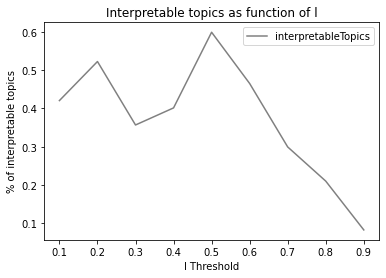

In [48]:
output_df = pd.DataFrame(output_final, columns = ['l', 'interpretableTopics', 'avgRev', 'stDevRev', 'minRev', 'maxRev'])
output_df.plot.line(x='l', y='interpretableTopics', color='grey')

plt.xlabel('l Threshold')
plt.ylabel('% of interpretable topics')
plt.title('Interpretable topics as function of l')

plt.show()

The next block of code will plot relevant statistics about the numnber of reviews associated with each salient topic as a funcion of *l*:

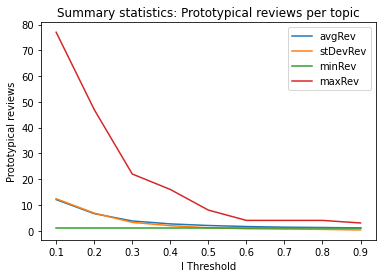

In [49]:
output_df.plot.line(x='l', y=['avgRev', 'stDevRev', 'minRev', 'maxRev'])

plt.xlabel('l Threshold')
plt.ylabel('Prototypical reviews')
plt.title('Summary statistics: Prototypical reviews per topic')

plt.show()

**Set optimal l based on results graphed above**

Your objective is to (1) maximize the percentage of topics from the corpus you can interpret, while (2) not having too many reviews to analyse for each topic.

### Step 3.2: Compute culture metrics on document-over-topic matrix

The document-over-topic matrix can be used to compute distance metrics across the documents in the corpus, and to understand the breadth of content covered by each document (as in the Herfindahl–Hirschman Index).

We compute three metrics of interest: average similarity, average focus, and average cross-entropy of the document-over-topic probability matrix. 

These three metrics summarize the shape of the matrix and tell us whether **people are similar in the content they write about** in their review and whether **they write many or few topics** in their document. 

Keep in mind that these metrics are not very useful, in absolute terms, and are generally used to compare corpora (summarizing, for instance, different organizations, or groups of individuals) among each other. 

Let's first define functions to compute the metrics, taking the document-over-topic probability matrix as input: 

In [50]:
def similarity_func(probMatrix): #takes in input array 
    #Transform probMatrix_df into 2D array

    i = 0
    j = 0
    
    df = pd.DataFrame()
    for i in range(0, len(probMatrix)): 
        jsd_list = []
        for j in range(0, len(probMatrix)): 
            jsd_list.append(jsd(probMatrix[i], probMatrix[j]))
            j = j+1
        df[str(i)] = jsd_list

    mask = np.ones(df.shape,dtype='bool')
    mask[np.triu_indices(len(df))] = False
    df_lower_diagonal = df[(df>-1)&mask]
    
    distance_list = []
    i = 0 
    for i in range(0, len(df)): 
    #Transform each column of df_lower_diagonal into list
        column_list = df_lower_diagonal[str(i)].values.tolist()
        #Drop nan values from column_list - to retain only actual values from lower diagonal 
        column_lower_diagonal_list = [x for x in column_list if (math.isnan(x) == False)]
        for d in column_lower_diagonal_list: 
            distance_list.append(d)
        i = i + 1
    sim = 1-(sum(distance_list) / float(len(distance_list))) #this will return similarity, instead of comph
    return sim

def focus_func(probMatrix_df):  #takes in input pandas df 
    N = probMatrix_df.shape[0]
    probMatrix = probMatrix_df.values
    foc = (sum(map(sum, np.square(probMatrix))))/N
    return foc 

def ent_avg(probMatrix):
    entropy_list = []
    for i in range(len(probMatrix)): 
        entropy_list.append(sp.stats.entropy(probMatrix[i]))
    return np.mean(entropy_list)

def cross_entropy(p, q):
    for i in range(len(p)):
        p[i] = p[i]+1e-12
    for i in range(len(q)):
        q[i] = q[i]+1e-12

    return -sum([p[i] * np.log2(q[i]) for i in range(len(p))])

def avg_crossEnt_func(probMatrix): #takes in input array 

    crossEntropy_list = []
    for i in range(len(probMatrix)):
        for j in range(len(probMatrix)): 
            if i > j:
                crossEntropy_local_list = []
                crossEntropy_local_list.append(cross_entropy(probMatrix[i], probMatrix[j]))
                crossEntropy_local_list.append(cross_entropy(probMatrix[j], probMatrix[i]))
                crossEntropy_list.append(np.mean(crossEntropy_local_list))
        
    return np.mean(crossEntropy_list)


Running the functions may take some time:

In [51]:
similarity_score = similarity_func(docs_topics)
focus_score = focus_func(docs_topics_df)
ace_score = avg_crossEnt_func(docs_topics)
print(similarity_score)
print(focus_score)
print(ace_score)

<ipython-input-50-c76b5f7ed415>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(i)] = jsd_list


0.41237132001592025
0.3995251365905126
10.368187923551263
